# Fine-tuning a BERT Model for Sentiment Analysis

## Abstract

This tutorial goes over sentiment analysis using BERT models fine-tuned on the "dair-ai/emotion" dataset from Hugging Face.  It will cover essential text preprocessing techniques on text sources from X (formerly Twitter), how to fine tune a BERT model on your data, and the performance evaluation of this model. Furthermore, the tutorial will also try to identify which BERT model gives the best performance for this particular task (detecting emotions from text). This notebook aims to provide a pipeline to analyze and understand sentiment and emotions from text, which could offer valuable insights for researchers in social sciences, marketing, and computational linguistics.


## Learning Objectives
<ul>

<li>Grasp the fundamentals of sentiment analysis.</li>
<li>Learn text preprocessing techniques essential for sentiment analysis.</li>
<li>Fine-tune a pretrained BERT model to classify text into different emotion classes.</li>
<li>Assess the performance of the BERT model.</li>
<li>Compare the performance of different BERT models for this sentiment analysis.</li>
</ul>

## Table of Content:

1. [Introduction](#introductionlink)
    * What is sentiment analysis
2. [Setup](#setuplink)
    * Loading Libraries and Setting up the Environment
    * Loading the Hugging Face Dataset
3. [Text Preprocessing](#textpreprocessinglink)
    * Tokenization
    * Padding
    * Data Loaders
4. [Getting the pretrained model](#creatingthemodellink)
    * BERT transformers
5. [Fine-tuning the model](#trainingthemodellink)
    * The learning rate
    * The Adam optimizer
    * The error loss function
    * Putting it all together
    * The Fine-tuning Loop
    * Evaluating the model's Performance after fine-tuning
6. [Testing the Model](#testingthemodellink)
    * The Model's Performance on the Test Data Set
    * Predicting Emotions from Text
7. [Comparison of BERT models](#comparisonofbertmodelslink)
    * Loading the Different BERT models
    * Comparing Model Performance
8. [Differences with Similar Online Tutorialss](#diffwithprosandconslink)
    * Pros
    * Cons
9. [Conclusion](#conclusionlink)
10. [References](#referenceslink)



<a id="introductionlink"></a>
## 1. Introduction

#### What is Sentiment Analysis?
Sentiment analysis is a natural language processing technique used to determine the sentiment or emotional tone expressed in a piece of text. It involves analyzing text data to identify and classify subjective information, such as positive, negative, or neutral sentiments. Sentiment analysis is commonly used in various applications, including social media monitoring, customer feedback analysis, brand reputation management and market research, where data may be hidden in natural language.

This tutorial is an extension of [a transformers tutorial](https://github.com/bentrevett/pytorch-sentiment-analysis) by Ben Trevett, in which a BERT model is used to detect the sentiment of comments from an IMDB dataset. In this tutorial, we will be using a BERT model to carry out sentiment analysis to detect the emotions conveyed in a message, trained using tweets from X (formerly Twitter). In addition to building the model, we will also be comparing its performance to different BERT models trained with the same hyper parameters to observe which will give the best performance for the task at hand.

<a id="setuplink"></a>
## 2. Setup

#### Loading Libraries and Setting up the Environment
Firstly, we need to install the necessary libraries and load the sentiment-labeled dataset. We will use the "[dair-ai/emotion](https://huggingface.co/datasets/dair-ai/emotion)" dataset from Hugging Face, which contains tweets labeled with different emotions.

In [1]:
import collections
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import tqdm
import transformers
from torch.utils.data import DataLoader
import pandas as pd

Random numbers from numpy and pytorch will be used in the learning however, because the model needs to be reproducible, a seed is used in these libraries to ensure that these random numbers can be reproduced. We will set the random seed for all the libraries that we will be using to 1234 however, this could be set to an arbitrary value.

In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#### Loading the HuggingFace Dataset

We will use the `datasets` library from Hugging Face to load the "dair-ai/emotion" dataset. This dataset contains tweets labeled with different emotions, including anger, joy, sadness, love and surprise. HuggingFace's dataset library provides a simple way to load the dataset and split it into train, validation and test sets which will be needed for fine-tuning, validating and testing our model respectively.

In [3]:
train_data,validation_data,test_data = load_dataset("dair-ai/emotion", split=["train","validation","test"], trust_remote_code=True)

Just to ensure that the data has been imported correctly, we can print some information on the dataset. In this case, printing all three datasets returns the number of samples in each dataset showing the dataset has been imported correctly.

In [4]:
print(train_data, validation_data, test_data)

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
}) Dataset({
    features: ['text', 'label'],
    num_rows: 2000
}) Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})


<a id="dataset"></a>
It is important to note that the datasets are [Dataset](https://huggingface.co/docs/datasets/en/index) objects because we got them from the datasets library by Hugging Face. This will be important to remember later on in the tutorial. Before we begin to build the model, we need to understand the data that we have. We can do this by answering these three questions:

1. What are the columns in the dataset?
2. What is the format of the dataset (specifically the text)?
3. What are the classes (emotions) of our entries in the dataset?

According to the [hugging face website](https://huggingface.co/datasets/dair-ai/emotion) that has all the metadata for the dataset, the dataset has the following columns:
- text: the text of the tweet
- label: the emotion label of the tweet

In order to observe what the data is like, we can print out some values from the dataset to understand it better.


In [5]:
pd.DataFrame({
    "text":train_data['text'][:10],
    "label":train_data['label'][:10],
})

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


From the documentation of this dataset and by observing some of the values in the dataset, it is clear that the text is of type `string`. The metadata states that the labels taken on a numerical values from 0 to 5 where 0 is sadness, 1 is joy, 2 is love, 3 is anger, 4 is fear, and 5 is surprise. We can use this to view the number of samples in each class and plot a bar chart to visualize the distribution of the classes in the dataset with clear labels.


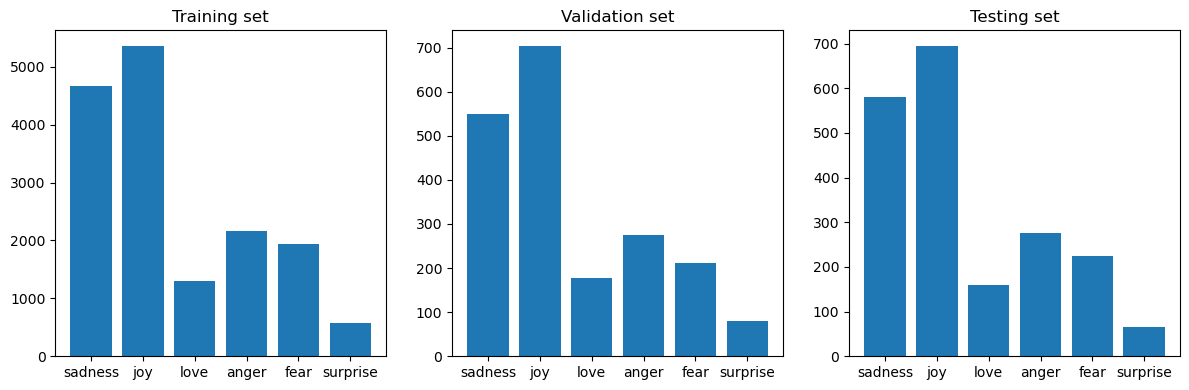

In [6]:
values_train,counts_train=np.unique(train_data['label'], return_counts=True)
values_validation,counts_validation=np.unique(validation_data['label'], return_counts=True)
values_test,counts_test=np.unique(test_data['label'], return_counts=True)

x_labels= ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1).title.set_text("Training set")
plt.bar(values_train, counts_train)
plt.xticks(values_train, x_labels)
plt.tight_layout()

plt.subplot(1,3,2).title.set_text("Validation set")
plt.bar(values_validation, counts_validation)
plt.xticks(values_validation, x_labels)
plt.tight_layout()

plt.subplot(1, 3, 3).title.set_text("Testing set")
plt.bar(values_test, counts_test)
plt.xticks(values_test, x_labels)
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.show()

From the distribution of the data, it is clear that the data has already been [stratified](https://towardsdatascience.com/what-is-stratified-cross-validation-in-machine-learning-8844f3e7ae8e) (each set contains approximately the same percentage of samples of each target class as the complete set) to ensure that there is a fair representation of each class during the fine-tuning phase of our algorithm. This can be seen by the similar proportions of each class across training, validation and testing sets.

<a id="textpreprocessinglink"></a>
## 3. Text Preprocessing
#### Tokenization
In order to carry out sentiment analysis on a piece of text, we need to change the text to tokens, which are numerical values which can be processed by our model. This is done by firstly breaking down the token into smaller units called tokens and thereafter, assigning values to the tokens created.

Hugging Face offers a library that can handle the tokenization for us, taking away the need to manually handle all of this. All we need to do is call `AutoTokenizer.from_pretrained` and pass in the transformer model we will be using. In this case we will use the BERT tokenizer as we are using a BERT transformer.



In [7]:
transformer_name ="bert-base-cased"

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name,return_attention_mask=False, return_token_type_ids=False)

We are using the [bert-base-cased](https://huggingface.co/google-bert/bert-base-cased) model for this part of the tutorial, however there are many more models of BERT that can all be found on the Hugging face [BERT community](https://huggingface.co/google-bert). We will look at some of these later in the tutorial. The bert-base-cased model is one of the smaller sized models, however this will suffice for the purpose of this tutorial. To get a better understanding of how tokenization works, we will first break down each step involved. Firstly, the text will be converted to tokens. In this case, each word is considered a unique token.

In [8]:
tokenizer.tokenize("hello world!")

['hello', 'world', '!']

Next, the tokens need to be converted to numerical values. Calling the `encode` function converts the tokens to the numerical values produced when the string is tokenized.

In [9]:
tokenizer.encode("hello world!")

[101, 19082, 1362, 106, 102]

To show that the library has tokenized our text correctly, calling `convery_ids_to_tokens` and passing in the numerical value we obtained should return the tokens we had before, showing that the tokenization works.

In [10]:
tokenizer.convert_ids_to_tokens(tokenizer.encode("hello world"))

['[CLS]', 'hello', 'world', '[SEP]']

We do not need to call these functions each time we want to tokenize our text; this was simply shown to help gain a better understanding of what exactly our tokenizer is doing. We can simply pass in the text we would like to tokenize into the `tokenizer` which will return a `dict` object. The tokens we want to keep are in the `'input_ids'` key from the `dict` returned.

In [11]:
tokenizer("hello world!")

{'input_ids': [101, 19082, 1362, 106, 102], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}

We now need to tokenize all the values in our datasets. We will do this by passing each tweet from the dataset into the tokenizer we created, and storing these tokenized values. We can create a function called `tokenize` to help perform this on each text entry in the datasets.

In [12]:
def tokenize(data_point):
    ids = tokenizer(data_point["text"])["input_ids"]
    return {"ids": ids}

As mentioned earlier, the datasets are `Dataset` objects which makes it difficult to directly alter the object and add an "ids" attribute that will store the tokenized values. However, the Dataset object offers a `map` method that allows us to pass in a function that can alter the object for us and add in an extra attribute. This is what we will use to add the "ids" attribute.

In [13]:
train_data=train_data.map(tokenize)
validation_data=validation_data.map(tokenize)
test_data=test_data.map(tokenize)

#### Padding
BERT can handle sequences of text of varying lengths however, it does require some pre-processing and the text must all be less than a predefined maximum sequence length. Sequences shorter than this maximum are padded with special tokens to create a uniform input size suitable for batch processing and efficient computation, while exceptionally long sequences may need to be truncated. This padding approach allows BERT to effectively process sequences of differing lengths.
<br>
<br>
If we take a look at the length of the different token sequences, it is clear that these sequences are all of different lengths. We can observe the first few token sequences which show that the lengths are differnt.

In [14]:
pd.DataFrame({
    "Text":train_data["text"][:10],
    "Tokens":train_data["ids"][:10],
    "Length of tokens": [len(train_data["ids"][i]) for i in range(10)]
})

,Text,Tokens,Length of tokens
0,i didnt feel humiliated,"[101, 178, 1238, 1204, 1631, 21820, 21896, 102]",8
1,i can go from feeling so hopeless to so damned...,"[101, 178, 1169, 1301, 1121, 2296, 1177, 24858...",23
2,im grabbing a minute to post i feel greedy wrong,"[101, 13280, 10810, 170, 2517, 1106, 2112, 178...",12
3,i am ever feeling nostalgic about the fireplac...,"[101, 178, 1821, 1518, 2296, 1185, 19760, 1100...",22
4,i am feeling grouchy,"[101, 178, 1821, 2296, 176, 22454, 1183, 102]",8
5,ive been feeling a little burdened lately wasn...,"[101, 178, 2707, 1151, 2296, 170, 1376, 11904,...",17
6,ive been taking or milligrams or times recomme...,"[101, 178, 2707, 1151, 1781, 1137, 6159, 6512,...",29
7,i feel as confused about life as a teenager or...,"[101, 178, 1631, 1112, 4853, 1164, 1297, 1112,...",20
8,i have been with petronas for years i feel tha...,"[101, 178, 1138, 1151, 1114, 11109, 15789, 111...",25
9,i feel romantic too,"[101, 178, 1631, 6376, 1315, 102]",6


We need to make the lengths the same in order for the BERT model to be fine-tuned and we can do this by setting a required length that all tokens should be, and adding padding tokens to the sequences that are not quite long enough. 

The tokenizer from the tranformers library comes with an attribute `pad_token_id` that stores a padding token that we can add to the end of each sequence of tokens that is shorter than the required length.

In [15]:
pad_index = tokenizer.pad_token_id

To add the pad tokens to the `id` sequences, we need to define a function that will do this for us and this function will be passed into a data loader that helps prepare our data for the BERT. The function `collate_fn` will take a batch and add padding to the sequences that are not long enough, ensuring all inputs are of fixed size.

In [16]:
def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

#### Data Loaders

The PyTorch `DataLoader` is an essential tool for training BERT models. It automatically manages the creation of data batches, ensuring they are correctly padded and formatted for BERT. The DataLoader optimizes how data is fetched, speeding up the training process while providing the flexibility to shuffle data between training rounds (epochs). This shuffling helps prevent the model from overfitting.  The DataLoader will let us focus on training the BERT model without worrying about the complexities of data preparation. As we are working with a training, validation and testing set, we will need to create a DataLoader for each one of these sets.


In [17]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
validation_data = validation_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [18]:
batch_size = 8

train_data_loader=DataLoader(dataset=train_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
validation_data_loader=DataLoader(dataset=validation_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_data_loader=DataLoader(dataset=test_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

We can define how large each batch will be in the `batch_size` variable and the data loader will automatically split the data into batches of the defined size.

<a id="creatingthemodellink"></a>
## 4. Getting the Pretrained Model

#### BERT Transformers
At this point, we need to load the BERT model that will be fine-tuned further, in addition to the pretraining that the model already has.

In [19]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

Training a powerful language model like BERT from scratch requires a massive amount of data and significant computational resources. Pre-trained models, on the other hand, have already been trained on vast datasets of text, capturing valuable general knowledge about language. By using the pre-trained BERT model, we can leverage this pre-acquired knowledge as a foundation. We can then fine-tune the model on our dataset reducing the time and computational resources needed significantly. This fine-tuning allows the model to specialize in a specific classification task, which in this case would be sentiment analysis - allowing us to achieve better results compared to training the model entirely from scratch.

Now, we need to define our model. We can do this creating a class that defines the neural network architecture which will use the pre-trained BERT model (`transformer`) for classification. It initializes a linear classification layer (`self.fc`) to map BERT's internal representations (`hidden_dim`) to our desired number of output classes (`output_dim`). The class also provides flexibility to freeze the pre-trained BERT weights (`if freeze: ...`) during training.  During a forward pass, the forward method extracts the BERT model's output, including the hidden states and attention weights, and uses the `[CLS]` token's representation for final class prediction

In [20]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        attention = output.attentions[-1]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        return prediction


## source: https://github.com/bentrevett/pytorch-sentiment-analysis

Creating the `Transformer` class in this way allows us to easily fine tune different BERT models later as well. It separates the core BERT model from the task-specific components, improving readability and maintainability. We can then create the model using the Transformer class we just defined and initializing it with the `bert-base-cased` model, the output dimension, which in this case is 6 (as we have 6 possible target classes), and the freeze option.

In [21]:
output_dim = 6 #we want to get the size of the output layer, which in this case should be the size of the number of classes we have
freeze = False

model = Transformer(transformer, output_dim, freeze)

The `freeze` parameter is a boolean flag to control whether to freeze the BERT model's weights during training or not. If `freeze` is set to `True`, gradient calculations for all parameters within the model get disabled, effectively freezing its weights. Setting this to false allows the BERT's weights to be fine-tuned for the specific task, adapting it even further.

<a id="trainingthemodellink"></a>
## 5. Fine-tuning the Model
#### The Learning Rate
When fine-tuning our model, we need to have a learning rate that will help adjust the weights of our model and allow convergence of the model. It provides the size of the steps we take when adjusting the model's weights to improve its performance. We will use a small learning rate so that the model can make gradual adjustments to its weights, allowing it to build upon its pre-trained knowledge rather than forgetting it.

In [22]:
lr = 1e-5

#### The Adam Optimizer
Once we define the learning rate, we can create an [optimizer](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/) that will update the weights of our model to minimize the error (loss). In this tutorial, we will use the [Adam optimizer](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/). Adam intelligently adjusts learning rates for different parts of our model, helping it find optimal solutions quickly. This adaptive behavior makes it well-suited to the complex nature of fine-tuning with text data. Additionally, Adam is generally robust to different settings, making it a reliable and beginner-friendly choice.

We can define the Adam optimizer that will be responsible for updating our model's weights during the training process.

In [23]:
optimizer = optim.Adam(model.parameters(), lr=lr)

#### The error Loss Function
In order for the optimizer to reduce the error (loss), we need to define a loss function that it can use. The loss calculated can then be propagated back into the network to calculate the new weights of the parameters in the model. In this tutorial, we will use the [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) function. [Cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) increases as the predicted probability diverges from the actual label therefore, to minimize the loss, the prediction must be close to the actual label. A perfect model has a cross-entropy loss of 0 (the smaller the loss the, better the performance of the model).

In [24]:
loss_fn = nn.CrossEntropyLoss()

This is a predefined function from the PyTorch `nn` module specifically designed for classification problems where a model needs to choose one class among multiple options. During training, it compares the probabilities our model assigns to each class with the true target label. The further our model's predictions are from the correct answer, the larger the 'error' it generates, which is then back propagated in the model.

#### Putting it all Together
Now that we have all the building blocks to fine-tune our model, we can go ahead and put them together in a single function that we can call. We will pass in the data loader created earlier, our model, the loss function, our optimizer, and the device we would like to use for training (e.g., CPU or GPU). The `train` function has a lot to unpack however, each line will be covered briefly here:

* `for batch in tqdm.tqdm(data_loader, desc="training...")`: Iterates over batches of data from the data loader while `tqdm` simply provides a progress bar to help track progress through the training.

* `ids = batch["ids"].to(device)`: Extracts input IDs from the current batch and sends them to the specified device.

* `label = batch["label"].to(device)`: Extracts corresponding labels and also sends them to the device.

* `prediction = model(ids)`: Passes the input data through the model to get predictions.

* `loss = criterion(prediction, label)`: Calculates the loss value using the defined loss function `(nn.CrossEntropyLoss)` by comparing the predictions to the true labels.

* `accuracy = get_accuracy(prediction, label)`: Calculates the accuracy of the predictions for the current batch. This is a function that we define.

* `optimizer.zero_grad()`: Clears any previously calculated gradients from the optimizer, preparing it for the next update.

* `loss.backward()`: Calculates gradients of the loss with respect to the model's parameters.

* `optimizer.step()`: Updates the model's weights based on the calculated gradients.

* `epoch_losses.append(loss.item())`: Appends the loss of the current batch to the list.

* `epoch_accs.append(accuracy.item())`: Appends the accuracy of the current batch to the list.

The function then returns the mean of the losses of all the batches and the mean of the accuracies of all the batches.

In [25]:
def train(data_loader, model, loss_fn, optimizer, device):
    model.train() #set the model in training mode
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = loss_fn(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


  ## source: https://github.com/bentrevett/pytorch-sentiment-analysis

We will also need a function that we can use to evaluate the performance of our model to check how well it performs against unseen data. The exact functionality of each line is similar to that in the `train` function however, the `evaluate` does not update the model's weights after. Its focus is on observing the performance of the model.

In [26]:
def evaluate(data_loader, model, loss_fn, device):
    model.eval() #set the model in evaluation mode
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = loss_fn(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)


  ## source: https://github.com/bentrevett/pytorch-sentiment-analysis

We also need to define the accuracy function which will measure how many predictions our model got right within a batch of data during training or evaluation. We can define a function called  `get_accuracy` that calculates the proportion of correct predictions made by the model within a batch of data. It uses `torch.where` to create a temporary tensor that encodes correct predictions as 1s and incorrect ones as 0s. Summing this tensor gives us the number of correct predictions, which is then divided by the total number of examples to arrive at the accuracy. An accuracy of 1 would be perfect accuracy, therefore the closer to 1 the accuracy is, the better the performance of the model is.

In [27]:
def get_accuracy(prediction, label):
    predicted_classes = prediction.argmax(dim=-1)
    correct = torch.where(predicted_classes == label, 1, 0).sum()
    accuracy = correct / len(label) 
    return accuracy

In order to speed up the fine-tuning and evaluation of the model, we can use an NVIDIA graphics card with CUDA cores. If this is not available, the function can still work as intended, but will run on the CPU which makes for much slower computation. 

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We can then move the model, loss function, and subsequently the data, all to the available device for computation during training. 

In [29]:
model = model.to(device)
loss_fn = loss_fn.to(device)

#### The Fine-tuning Loop 
We now need to fine-tune the model for a set number of epochs. During each epoch, we use batches of data from the training set using the `train` function defined earlier, then evaluate how well the model is doing on the validation set using the `evaluate` function defined earlier. This feedback from the validation set helps us track progress and save the best performing version of our model using `torch.save`. The best performing model is determined by the model that has had the lowest validation loss which is the mean of the loss function applied on the validation set. We also keep track of accuracies for both training and validation sets which will be used later to visualize the performance of the model.

In [ ]:
n_epochs = 3
best_validation_loss = float("inf")

train_losses=[]
train_accs=[]
validation_losses=[]
validation_accs=[]

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, loss_fn, optimizer, device
    )
    validation_loss, validation_acc = evaluate(validation_data_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    validation_losses.append(validation_loss)
    validation_accs.append(validation_acc)
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(model.state_dict(), transformer_name+".pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"validation_loss: {validation_loss:.3f}, validation_acc: {validation_acc:.3f}")

#### Evaluating the model's Performance after Fine-tuning
We can then plot the performance of our model by looking at the change in the loss with each epoch and the change of accuracy over time of both the training and evaluation sets. 

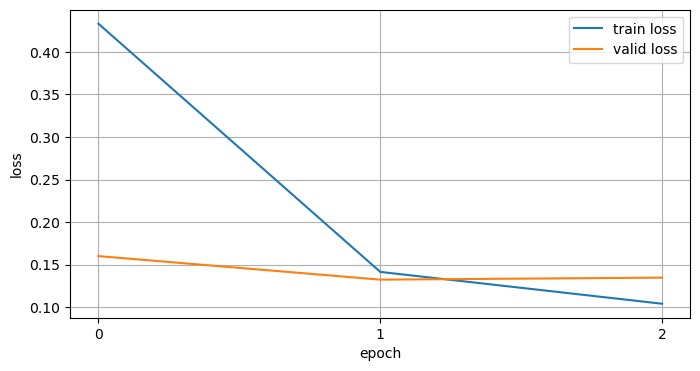

In [31]:
def plot_losses():
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_losses, label="train loss")
    ax.plot(validation_losses, label="valid loss")
    ax.set_xlabel("epoch")
    ax.set_ylabel("loss")
    ax.set_xticks(range(n_epochs))
    ax.legend()
    ax.grid()

plot_losses()

The reduction of the loss function for the training set with each epoch shows that the model is performing as expected, as a reduction in the loss means the model is improving, and therefore, learning.

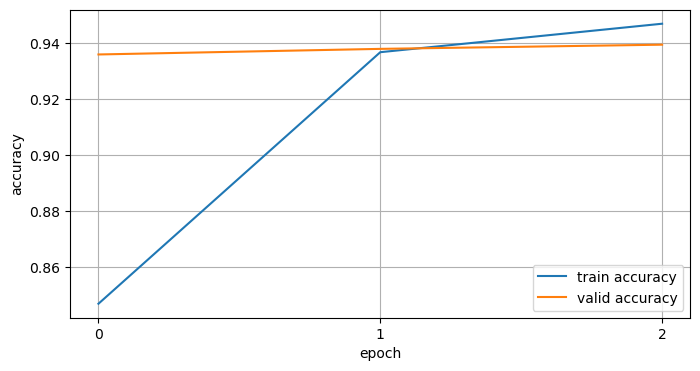

In [32]:
def plot_accs():
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_accs, label="train accuracy")
    ax.plot(validation_accs, label="valid accuracy")
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.set_xticks(range(n_epochs))
    ax.legend()
    ax.grid()
    
plot_accs()

The rise in the accuracy of the model's output with each epoch further shows that the model is improving, showing that the model works as intended. 

<a id="testingthemodellink"></a>
## 6. Testing the Model 

#### The Model's Performance on the Test Data Set
Now that we have created the model and trained it successfully, we can test its performance on the test data set which gives us a chance to see how the model performs on data it has never seen before. We stored the model in a file (`bert-base-cased.pt`) and can therefore retrieve the model from this. It is currently stored as a state dictionary, therefore we need to call the [`load_state_dict`](https://pytorch.org/tutorials/recipes/recipes/what_is_state_dict.html) function from pytorch. We can then evaluate its performance on the test dataset. 

In [ ]:
model.load_state_dict(torch.load(transformer_name+".pt"))

test_loss, test_acc = evaluate(test_data_loader, model, loss_fn, device)

In [34]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.139, test_acc: 0.932


#### Predicting Emotions from Text
Now that we have fine-tuned the model and tested it, we can go ahead and start using it for its intended purpose; predicting emotions. We can define a function that will take text as input and use our model to predict the sentiment of the text input. The function will tokenize the text and use the model to predict the emotion. It gets the probability of each class being the prediction using the `torch.softmax` function which takes a set of numbers (in the form of a tensor) and transforms them into a set of probabilities that sum up to 1. It then selects the class with the highest probability using the `argmax` function. This class is returned as the predicted emotion along with its probability.

In [35]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

We can then try different texts to see what the model predicts the emotions of the text are. 

In [36]:
emotion={
    0:"sadness",
    1:"joy",
    2:"love",
    3:"anger",
    4:"fear",
    5:"surprise"
}

In [37]:
text = "I hate doing Coursework!"

value,confidence=predict_sentiment(text, model, tokenizer, device)
print(f"Predicted emotion: {emotion[(value)]}, with confidence {confidence}")

Predicted emotion: anger, with confidence 0.90799480676651


In [38]:
text = "I actually like coursework"

value,confidence=predict_sentiment(text, model, tokenizer, device)
print(f"Predicted emotion: {emotion[(value)]}, with confidence {confidence}")

Predicted emotion: joy, with confidence 0.8418980240821838


In [39]:
text = "I actually like coursework. I'm being sarcastic"

value,confidence=predict_sentiment(text, model, tokenizer, device)
print(f"Predicted emotion: {emotion[(value)]}, with confidence {confidence}")

Predicted emotion: anger, with confidence 0.9942889213562012


In [40]:
text = "I'm shocked I haven't graduated yet"

value,confidence=predict_sentiment(text, model, tokenizer, device)
print(f"Predicted emotion: {emotion[(value)]}, with confidence {confidence}")

Predicted emotion: surprise, with confidence 0.9876880049705505


The model is able to predict the emotions from the text which means the BERT model we fine-tuned works as we intened it to.

<a id="comparisonofbertmodelslink"></a>
## 7. Comparison of BERT models


#### Loading the Different BERT Models 
We will now compare the performance of different bert models on predicting the emotions of the tweets in our dataset. In order to make this tutorial more concise and easier to follow, we will make a function to build the model by calling functions that all assist in building the model. The only difference between each model will be the pretrained BERT model that we use to create these models. All the functions used were defined earlier in the tutorial and so will not be explained in this section.

We will be comparing the performance of the following models:

* bert-base-uncased
* bert-base-cased
* bert-large-uncased
* bert-large-cased

These models have already been fine-tuned to make this tutorial easier to follow and the models have been saved to `.pt` files with the name of the respective pretrained model used. 
In this section we will be loading the models and evaluating their performance on the test data set. We will also look at the amount of time taken to fine-tune each model as these were significantly different due to the size of each model. 

I created a function that we can call to load the transformer, tokenize our test data using the specific transformer's tokenizer, create a data loader for the test dataset, load the pretrained weights of the model, and lastly evaluate the model. The function then returns the loss (using the `loss_fn` defined earlier), the accuracy (using `get_accuracy` function defined earlier) of the model, and the hidden size (number of nodes in the hidden layers) of the model. This will all be important for comparing the performance of each model.  

In [41]:
def get_model_and_evaluate(transformer_name):
    test_data = load_dataset("dair-ai/emotion", split="test", trust_remote_code=True)
    tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name,return_attention_mask=False, return_token_type_ids=False)
    test_data=test_data.map(tokenize)
    test_data = test_data.with_format(type="torch", columns=["ids", "label"])
    test_data_loader=DataLoader(dataset=test_data, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    my_transformer = transformers.AutoModel.from_pretrained(transformer_name)
    my_model = Transformer(my_transformer, output_dim, freeze)
    my_model=my_model.to(device)
    my_model.load_state_dict(torch.load(transformer_name+".pt"))    
    model_loss,model_accuracy = evaluate(test_data_loader, my_model, loss_fn, device)
    return model_loss,model_accuracy, my_transformer.config.hidden_size

With the function defined, we can go ahead and call it for each pretrained BERT model we are looking at. 

In [ ]:
bert_base_uncased_data=get_model_and_evaluate("bert-base-uncased")
bert_base_cased_data=get_model_and_evaluate("bert-base-cased")
bert_large_uncased_data=get_model_and_evaluate("bert-large-uncased")
bert_large_cased_data=get_model_and_evaluate("bert-large-cased")

The amount of time taken to fine-tune each model was also noted. These times will be added to the data that we have on the models as well and the information can be plotted in a table. 

#### Comparing Model Performance
We can get the results returned from the function and store these in a dict object. That way we can easily output these results to a pandas data frame.

In [43]:
model_names=["bert-base-uncased","bert-base-cased","bert-large-uncased","bert-large-cased"]
model_losses=[bert_base_uncased_data[0],bert_base_cased_data[0],bert_large_uncased_data[0],bert_large_cased_data[0]]
model_accs=[bert_base_uncased_data[1],bert_base_cased_data[1],bert_large_uncased_data[1],bert_large_cased_data[1]]
time=[338,355,812,865]
tranformer_hidden_dimension=[bert_base_uncased_data[2],bert_base_cased_data[2],bert_large_uncased_data[2],bert_large_cased_data[2]]

The data frame allows us to easily make comparisons of the performance of each model, along with the amount of time to fine-tune the model and the number of nodes that each model has in its hidden layer to make a comparison of the sizes of the models.

In [46]:
df_data={"Model Names":model_names,"Model Losses":model_losses,"Model Accuracies":model_accs,"Time taken to Fine-Tune the Model (secs)":time,"Tranformer Hidden Dimension":tranformer_hidden_dimension}
pd.DataFrame(df_data)

,Model Names,Model Losses,Model Accuracies,Time taken to Fine-Tune the Model (secs),Tranformer Hidden Dimension
0,bert-base-uncased,0.160727,0.9280,338,768
1,bert-base-cased,0.138297,0.9295,355,768
2,bert-large-uncased,0.146855,0.9335,812,1024
3,bert-large-cased,0.148582,0.9305,865,1024


Our results show similar performance across all models for this dataset. This suggests that model selection should consider factors like fine-tuning time and the specific use cases. We can see that the large models took significantly longer to fine-tune as the have more nodes in their hidden layer however, these still gave about the same performance as the base models when fine-tuned with the same hyper parameters. Therefore, using the base models over the large models would be worth considering in different applications as they could slow down the amount of time taken to get a model that performs just as well as the base models. Ultimately, the application of these models should still dictate when each one is used. For example, if the dataset contains text with both upper and lower cased words, capitalization can signal emphasis or strong emotions, which means the cased models will be able to pick up this emotion, resulting in better predictions, where as the uncased models would not be able to. Furthermore, some words have different meanings with different casing. For example, "Polish" (nationality) and "polish" (to make shiny) or "I hate this" vs "I HATE this" which places more emphasis on the word "hate". A cased model might be better at understanding these distinctions in context.  

<a id="diffwithprosandconslink"></a>
## 8. Differences with Similar Online Tutorials
#### Pros
* Online resources found mostly train for binary calssification, this tutorial attempts to classify text into several classes (emotions).
* This tutorial compares the performance of different BERT models against each other and sees their performance when fine-tuned with the same hyper parameters on the same dataset where as most other online tutorials only show the performance of a single BERT transformer, which is usually the `"bert-base-uncased"` model.
* This tutorial attemtps to teach about sentiment analysis in general as well, as opposed to simply showing how to fine-tune the BERT model.
* The tutorial can easily be adapted to fit with any dataset that requires text classification.

#### Cons
* This tutorial can be a long read, and for those new to sentiment analysis, might not be as intuitive as some of the core concepts were not covered in great depth.
* Some of the explanations could have been more concise and worded better to help the readers understand why we are doing everything we did in this tutorial.

<a id="conclusionlink"></a>
## 9. Conclusion
This tutorial provided a practical exploration of fine-tuning BERT models for emotion classification. We covered dataset preparation, fine-tuning a model, performance evaluation, and a comparison of the performance of different BERT models.  Importantly, we also highlighted the influence of factors such as casing on model performance. This work aligns with existing research emphasizing the context-dependent nature of emotion detection in language (Seyeditabari et al., 2018). Future directions may include exploring larger datasets, more complex emotions,  and techniques to address potential biases in emotion classification systems.

<a id="references"></a>
## 10. References:
<a id="referenceslink"></a>
* https://github.com/bentrevett/pytorch-sentiment-analysis
* https://arxiv.org/abs/1810.04805
* https://www.analyticsvidhya.com/blog/2023/06/step-by-step-bert-implementation-guide/
* https://medium.com/@samia.khalid/bert-explained-a-complete-guide-with-theory-and-tutorial-3ac9ebc8fa7c
* https://huggingface.co/datasets/dair-ai/emotion/viewer/split/train
* https://tinkerd.net/blog/machine-learning/bert-tokenization/#:~:text=This%20page%20is%20all%20about,numerical%20value%20to%20each%20token
* Seyeditabari, A., Tabari, N. & Zadrozny, W. (2018). Emotion Detection in Text: a Review. arXiv, https://doi.org/10.48550/arXiv.1806.00674 [Accessed: 12 March 2024]